In [1]:
# coding: utf-8
import pandas as pd
import time
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import gc
from contextlib import contextmanager
import matplotlib.pyplot as plt
import pickle
import xgboost as xgb
from xgboost import plot_importance

@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')

path = '~/talkingdata/input/'

dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

columns = ['ip','app','device','os', 'channel', 'click_time', 'is_attributed']

In [2]:
print('start loading data')

with timer("Loading done"):
    with open('train_add_features_v3.csv.pkl','rb') as f:
        train=pickle.load(f)

    with open('y.csv.pkl','rb') as f:
        y = pickle.load(f)

start loading data
[Loading done] done in 288 s


In [4]:
params = {'eta': 0.05,
          'tree_method': "hist",
          'grow_policy': "lossguide",
#           'max_leaves': 1400,  
          'max_depth': 7, 
          'subsample': 0.9, 
#           'colsample_bytree': 0.7, 
          'colsample_bylevel':0.2,
          'min_child_weight':1,
          'alpha':0.4,
          'lambda':0.6,
          'objective': 'binary:logistic', 
#           'scale_pos_weight':9,
          'eval_metric': 'auc', 
          'nthread':24,
          'random_state': 99, 
          'silent': True}

In [5]:
del train['click_time']
del train['ip']
del train['app_by_channel_countuniq']
gc.collect()

213

In [6]:
train.columns

Index(['app', 'device', 'os', 'channel', 'hour', 'ip_count', 'os_device_count',
       'os_app_channel_count', 'ip_hour_count', 'ip_app_count',
       'ip_app_os_count', 'ip_device_count', 'app_channel_count',
       'ip_by_channel_countuniq', 'ip_device_os_by_app_countuniq',
       'ip_by_hour_countuniq', 'ip_by_app_countuniq', 'ip_app_by_os_countuniq',
       'ip_by_device_countuniq', 'cumcount_ip_dev_os_by_app',
       'cumcount_ip_by_os', 'ip_nextClick', 'ip_app_nextClick',
       'ip_channel_nextClick', 'ip_os_nextClick',
       'ip_app_device_os_channel_nextClick', 'ip_os_device_nextClick',
       'ip_os_device_app_nextClick', 'ip_os_device_app_prevClick',
       'next_click_counts', 'next_click_var', 'next_click_mean'],
      dtype='object')

In [7]:
# is_valid = True

target = "is_attributed"
# categorical = ['app','os','channel','hour','device']
predictors = list(set(train.columns)-set([target])-set(['click_time','ip','app_by_channel_countuniq']))

# if (is_valid == True):
    # Get 10% of train dataset to use as validation
x1, x2, y1, y2 = train_test_split(train, y, test_size=0.1, random_state=99)
dtrain = xgb.DMatrix(x1, y1)
dvalid = xgb.DMatrix(x2, y2)
del x1, y1, x2, y2 
gc.collect()
watchlist = [(dvalid, 'valid')]

In [8]:
model = xgb.train(params, dtrain, 1000, watchlist, maximize=True, early_stopping_rounds = 30, verbose_eval=5)
del dvalid
# else:
#     dtrain = xgb.DMatrix(train, y)
#     del train, y
#     gc.collect()
#     watchlist = [(dtrain, 'train')]
#     model = xgb.train(params, dtrain, 30, watchlist, maximize=True, verbose_eval=1)

del dtrain
gc.collect()

[0]	valid-auc:0.924701
Will train until valid-auc hasn't improved in 30 rounds.
[5]	valid-auc:0.950258
[10]	valid-auc:0.951438
[15]	valid-auc:0.955647
[20]	valid-auc:0.95718
[25]	valid-auc:0.959956
[30]	valid-auc:0.960512
[35]	valid-auc:0.960559
[40]	valid-auc:0.960585
[45]	valid-auc:0.960827
[50]	valid-auc:0.961339
[55]	valid-auc:0.96314
[60]	valid-auc:0.96494
[65]	valid-auc:0.966044
[70]	valid-auc:0.966948
[75]	valid-auc:0.967418
[80]	valid-auc:0.967464
[85]	valid-auc:0.967772
[90]	valid-auc:0.97039
[95]	valid-auc:0.971901
[100]	valid-auc:0.973956
[105]	valid-auc:0.97492
[110]	valid-auc:0.97572
[115]	valid-auc:0.976358
[120]	valid-auc:0.976893
[125]	valid-auc:0.977487
[130]	valid-auc:0.977919
[135]	valid-auc:0.978286
[140]	valid-auc:0.97863
[145]	valid-auc:0.978958
[150]	valid-auc:0.979426
[155]	valid-auc:0.979992
[160]	valid-auc:0.980351
[165]	valid-auc:0.980709
[170]	valid-auc:0.980897
[175]	valid-auc:0.98116
[180]	valid-auc:0.981489
[185]	valid-auc:0.981783
[190]	valid-auc:0.98198

21

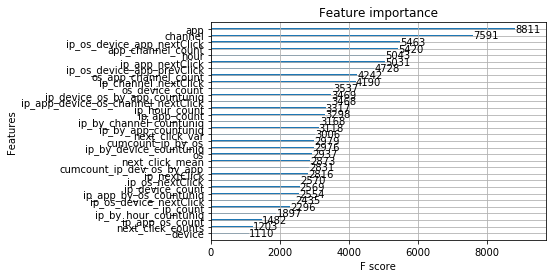

In [9]:
plot_importance(model)
plt.gcf().savefig('feature_importance_xgb.png')

In [48]:
# print('start loading test data')

# with timer("Loading done"):
# #     test_df = pd.read_csv(path+"test.csv", dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])

#     with open('testsup_add_features_v3.csv.pkl','rb') as f:
#         testsup_original=pickle.load(f)

# test_df['click_time']= pd.to_datetime(test_df['click_time'])
testsup_original['click_time']= pd.to_datetime(testsup_original['click_time'])

gc.collect()

84

In [49]:
testsup_original.head()

,ip,app,device,os,channel,click_time,hour,ip_count,os_device_count,os_app_channel_count,...,ip_app_nextClick,ip_channel_nextClick,ip_os_nextClick,ip_app_device_os_channel_nextClick,ip_os_device_nextClick,ip_os_device_app_nextClick,ip_os_device_app_prevClick,next_click_counts,next_click_var,next_click_mean
184903890,43570,3,1,18,379,2017-11-09 14:23:39,14,2980,11290342,59290,...,8224.0,18515.0,7148.0,18515.0,7148.0,18443.0,35.0,48,101714152.0,4919.808594
184903891,80528,3,1,13,379,2017-11-09 14:23:51,14,3493,49858614,282708,...,5531.0,5531.0,5531.0,5531.0,5531.0,5531.0,80900.0,134,66590652.0,2473.375977
184903892,32323,3,1,13,379,2017-11-09 14:25:57,14,9987,49858614,282708,...,5888.0,6015.0,6281.0,9408.0,6281.0,9331.0,81003.0,283,28742304.0,1521.921997
184903893,42887,3,1,17,379,2017-11-09 14:26:03,14,4776,11929590,64331,...,7207.0,10470.0,70471.0,NaN,70471.0,71400.0,81841.0,19,593441152.0,11714.388672
184903894,119289,58,1,30,120,2017-11-09 14:26:41,14,207694,1423159,334,...,5603.0,5603.0,6325.0,NaN,6670.0,NaN,11640.0,3,54090400.0,6439.500000


In [50]:
testsup_df.head()

,app,device,os,channel,hour,ip_count,os_device_count,os_app_channel_count,ip_hour_count,ip_app_count,...,ip_channel_nextClick,ip_os_nextClick,ip_app_device_os_channel_nextClick,ip_os_device_nextClick,ip_os_device_app_nextClick,ip_os_device_app_prevClick,next_click_counts,next_click_var,next_click_mean,is_attributed
184903890,3,1,18,379,14,2980,11290342,59290,102,498,...,18515.0,7148.0,18515.0,7148.0,18443.0,35.0,48,101714152.0,4919.808594,0.000172
184903891,3,1,13,379,14,3493,49858614,282708,193,677,...,5531.0,5531.0,5531.0,5531.0,5531.0,80900.0,134,66590652.0,2473.375977,0.000349
184903892,3,1,13,379,14,9987,49858614,282708,644,1578,...,6015.0,6281.0,9408.0,6281.0,9331.0,81003.0,283,28742304.0,1521.921997,0.000989
184903893,3,1,17,379,14,4776,11929590,64331,392,646,...,10470.0,70471.0,NaN,70471.0,71400.0,81841.0,19,593441152.0,11714.388672,0.000200
184903894,58,1,30,120,14,207694,1423159,334,19772,572,...,5603.0,6325.0,NaN,6670.0,NaN,11640.0,3,54090400.0,6439.500000,0.001418


In [54]:
# testsup_df['click_time'] = testsup_original['click_time']
testsup_df['ip'] = testsup_original['ip']

In [55]:
testsup_df.head()

,app,device,os,channel,hour,ip_count,os_device_count,os_app_channel_count,ip_hour_count,ip_app_count,...,ip_app_device_os_channel_nextClick,ip_os_device_nextClick,ip_os_device_app_nextClick,ip_os_device_app_prevClick,next_click_counts,next_click_var,next_click_mean,is_attributed,click_time,ip
184903890,3,1,18,379,14,2980,11290342,59290,102,498,...,18515.0,7148.0,18443.0,35.0,48,101714152.0,4919.808594,0.000172,2017-11-09 14:23:39,43570
184903891,3,1,13,379,14,3493,49858614,282708,193,677,...,5531.0,5531.0,5531.0,80900.0,134,66590652.0,2473.375977,0.000349,2017-11-09 14:23:51,80528
184903892,3,1,13,379,14,9987,49858614,282708,644,1578,...,9408.0,6281.0,9331.0,81003.0,283,28742304.0,1521.921997,0.000989,2017-11-09 14:25:57,32323
184903893,3,1,17,379,14,4776,11929590,64331,392,646,...,NaN,70471.0,71400.0,81841.0,19,593441152.0,11714.388672,0.000200,2017-11-09 14:26:03,42887
184903894,58,1,30,120,14,207694,1423159,334,19772,572,...,NaN,6670.0,NaN,11640.0,3,54090400.0,6439.500000,0.001418,2017-11-09 14:26:41,119289


In [44]:
print("Predicting the submission data...")

dtest = xgb.DMatrix(testsup_df)

testsup_df['is_attributed'] = model.predict(dtest, ntree_limit=model.best_ntree_limit)

Predicting the submission data...


In [46]:
testsup_df.head()

,app,device,os,channel,hour,ip_count,os_device_count,os_app_channel_count,ip_hour_count,ip_app_count,...,ip_channel_nextClick,ip_os_nextClick,ip_app_device_os_channel_nextClick,ip_os_device_nextClick,ip_os_device_app_nextClick,ip_os_device_app_prevClick,next_click_counts,next_click_var,next_click_mean,is_attributed
184903890,3,1,18,379,14,2980,11290342,59290,102,498,...,18515.0,7148.0,18515.0,7148.0,18443.0,35.0,48,101714152.0,4919.808594,0.000172
184903891,3,1,13,379,14,3493,49858614,282708,193,677,...,5531.0,5531.0,5531.0,5531.0,5531.0,80900.0,134,66590652.0,2473.375977,0.000349
184903892,3,1,13,379,14,9987,49858614,282708,644,1578,...,6015.0,6281.0,9408.0,6281.0,9331.0,81003.0,283,28742304.0,1521.921997,0.000989
184903893,3,1,17,379,14,4776,11929590,64331,392,646,...,10470.0,70471.0,NaN,70471.0,71400.0,81841.0,19,593441152.0,11714.388672,0.000200
184903894,58,1,30,120,14,207694,1423159,334,19772,572,...,5603.0,6325.0,NaN,6670.0,NaN,11640.0,3,54090400.0,6439.500000,0.001418


In [43]:
del testsup_df['click_time']
del testsup_df['ip']
del testsup_df['app_by_channel_countuniq']
gc.collect()

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x7feb2615d828>>
Traceback (most recent call last):
  File "/home/um003580/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/xgboost-0.71-py3.6.egg/xgboost/core.py", line 366, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


3977

In [18]:
predictors

['ip_app_os_count',
 'ip_os_device_nextClick',
 'ip_os_device_app_nextClick',
 'os',
 'ip_os_nextClick',
 'ip_by_channel_countuniq',
 'hour',
 'ip_app_nextClick',
 'ip_os_device_app_prevClick',
 'device',
 'ip_device_os_by_app_countuniq',
 'channel',
 'ip_app_count',
 'ip_count',
 'app',
 'ip_app_by_os_countuniq',
 'ip_app_device_os_channel_nextClick',
 'ip_by_device_countuniq',
 'ip_hour_count',
 'next_click_counts',
 'ip_by_hour_countuniq',
 'ip_device_count',
 'ip_channel_nextClick',
 'next_click_var',
 'os_app_channel_count',
 'cumcount_ip_by_os',
 'ip_by_app_countuniq',
 'next_click_mean',
 'app_channel_count',
 'ip_nextClick',
 'os_device_count',
 'cumcount_ip_dev_os_by_app']

In [30]:
import sys

print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_"):
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))
gc.collect()

|            Variable Name|    Memory|
 ------------------------------------ 
|                       In|       344|
|                      Out|       368|
|                  columns|       120|
|           contextmanager|       136|
|                    dtest|        56|
|                   dtypes|       368|
|                     exit|        56|
|                        f|       176|
|                       gc|        80|
|              get_ipython|        64|
|                      lgb|        80|
|                    model|        56|
|                       np|        80|
|                   params|       648|
|                     path|        69|
|                       pd|        80|
|                   pickle|        80|
|          plot_importance|       136|
|                      plt|        80|
|               predictors|       400|
|                     quit|        56|
|                      sys|        80|
|                   target|        62|
|                  test_d

41

In [22]:
del train

In [29]:
gc.collect()

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x7feae8591ba8>>
Traceback (most recent call last):
  File "/home/um003580/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/xgboost-0.71-py3.6.egg/xgboost/core.py", line 366, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


757

In [27]:
# target = "is_attributed"
# categorical = ['app','os','channel','hour','device']
predictors = list(set(testsup_df.columns)-set(['click_time','ip','app_by_channel_countuniq']))

In [33]:
x2.columns

NameError: name 'x2' is not defined

In [42]:
set(model.feature_names) - set(testsup_df[predictors].columns)

set()

In [56]:
print('projecting prediction onto test')

join_cols = ['ip', 'app', 'device', 'os', 'channel', 'click_time']
all_cols = join_cols + ['is_attributed']

test_df = test_df.merge(testsup_df[all_cols], how='left', on=join_cols)

test_df = test_df.drop_duplicates(subset=['click_id'])

print("Writing the submission data into a csv file...")

test_df[['click_id', 'is_attributed']].to_csv('xgboost.csv', index=False)

print("All done...")

projecting prediction onto test
Writing the submission data into a csv file...
All done...


In [57]:
test_df.head()

,click_id,ip,app,device,os,channel,click_time,is_attributed
0,0,5744,9,1,3,107,2017-11-10 04:00:00,0.000792
1,1,119901,9,1,3,466,2017-11-10 04:00:00,0.000050
2,2,72287,21,1,19,128,2017-11-10 04:00:00,0.000027
3,3,78477,15,1,13,111,2017-11-10 04:00:00,0.000113
4,4,123080,12,1,13,328,2017-11-10 04:00:00,0.000091
